# Overview
Input data is
1. a list of CVEs (synthesized to reflect a real organization)
2. the enriched CVSS score with the Exploit Code Maturity/Exploitability (E) Temporal Metric cvss-bt.csv from https://github.com/t0sche/cvss-bt

Code and analysis is provided for ACME Inc CVEs to help understand their CVEs:



1. Enrich CVE data with exploitation data sources
2. Plot CVE data with CVSS and EPSS scores
3. Plot Count of CVEs At or Above Each CVSS Base Score and CVSS v3 with Temporal
4. Metric - Exploit Code Maturity (E) Score
5. Plot Percentage of CVEs above an EPSS score
6. Calculate EPSS Percentiles for their CVEs (and compare to overall CVE EPSS Percentiles)


In [ ]:
# Need these for the logic
import pandas as pd
import numpy as np
import random

# Need these for the plots
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
import seaborn as sns
from IPython.display import Image #to display images in github from this notebook

EPSS_THRESHOLD_LOW = 0.1


# Get Enrichment data

In [ ]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    # Run code specific to Google Colab environment
    print("Running in Google Colab")
    #Download the input data file
    FILE_PATH="./cvss-bt.csv"
    URL="https://raw.githubusercontent.com/t0sche/cvss-bt/main/cvss-bt.csv"

    !if [ ! -f $FILE_PATH ]; then \
        wget -O $FILE_PATH $URL; \
    else \
        echo "File already exists: $FILE_PATH"; \
    fi
    df = pd.read_csv('./cvss-bt.csv')
else:
    # Run code for other environments
    print("Not running in Google Colab")
    df = pd.read_csv('../data_in/cvss_bt/cvss-bt.csv.gz', compression="gzip")

    # suppress error for environment variable APPDATA missing on OSs other than Windows
    import os
    os.environ['APPDATA'] = ""
    import pandasgui


Running in Google Colab
--2024-03-16 14:45:58--  https://raw.githubusercontent.com/t0sche/cvss-bt/main/cvss-bt.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48742731 (46M) [text/plain]
Saving to: ‘./cvss-bt.csv’

./cvss-bt.csv       100%[===================>]  46.48M   176MB/s    in 0.3s    

2024-03-16 14:45:59 (176 MB/s) - ‘./cvss-bt.csv’ saved [48742731/48742731]



<ipython-input-2-e008ec7f25b5>:15: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./cvss-bt.csv')


In [ ]:
# Drop rows where 'cvss' column value is zero
df = df[df['base_score'] != 0]
df = df[df['cvss-bt_score'] != 0]


In [ ]:
# Convert the column to float with coercion
df['epss'] = pd.to_numeric(df['epss'], errors='coerce')

### Add EPSS Percentile
This is also available from EPSS API

In [ ]:
def percentile_rank(column):
   return column.rank(pct = True)

In [ ]:
df['EPSS_Percentile'] = percentile_rank(df['epss'])
df

,cve,cvss-bt_score,cvss-bt_severity,cvss-bt_vector,cvss_version,base_score,base_severity,base_vector,assigner,published_date,epss,cisa_kev,vulncheck_kev,exploitdb,metasploit,nuclei,poc_github,EPSS_Percentile
0,CVE-1999-0095,9.0,HIGH,AV:N/AC:L/Au:N/C:C/I:C/A:C/E:POC,2.0,10.0,HIGH,AV:N/AC:L/Au:N/C:C/I:C/A:C,cve@mitre.org,1988-10-01T04:00Z,0.07764,False,False,True,False,False,False,0.940310
1,CVE-1999-0082,8.5,HIGH,AV:N/AC:L/Au:N/C:C/I:C/A:C/E:U,2.0,10.0,HIGH,AV:N/AC:L/Au:N/C:C/I:C/A:C,cve@mitre.org,1988-11-11T05:00Z,0.01500,False,False,False,False,False,False,0.865973
2,CVE-1999-1471,6.1,MEDIUM,AV:L/AC:L/Au:N/C:C/I:C/A:C/E:U,2.0,7.2,HIGH,AV:L/AC:L/Au:N/C:C/I:C/A:C,cve@mitre.org,1989-01-01T05:00Z,0.00043,False,False,False,False,False,False,0.068135
3,CVE-1999-1122,3.9,LOW,AV:L/AC:L/Au:N/C:P/I:P/A:P/E:U,2.0,4.6,MEDIUM,AV:L/AC:L/Au:N/C:P/I:P/A:P,cve@mitre.org,1989-07-26T04:00Z,0.00060,False,False,False,False,False,False,0.234476
4,CVE-1999-1467,8.5,HIGH,AV:N/AC:L/Au:N/C:C/I:C/A:C/E:U,2.0,10.0,HIGH,AV:N/AC:L/Au:N/C:C/I:C/A:C,cve@mitre.org,1989-10-26T04:00Z,0.00299,False,False,False,False,False,False,0.687896
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241585,CVE-2024-24156,6.0,MEDIUM,CVSS:3.1/AV:N/AC:L/PR:N/UI:R/S:U/C:N/I:N/A:H/E:U,3.1,6.5,MEDIUM,CVSS:3.1/AV:N/AC:L/PR:N/UI:R/S:U/C:N/I:N/A:H,cve@mitre.org,2024-03-16T06:15Z,0.00043,False,False,False,False,False,False,0.068135
241586,CVE-2024-28639,9.0,CRITICAL,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H/E:U,3.1,9.8,CRITICAL,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H,cve@mitre.org,2024-03-16T06:15Z,0.00043,False,False,False,False,False,False,0.068135
241587,CVE-2024-28069,9.0,CRITICAL,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H/E:U,3.1,9.8,CRITICAL,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H,cve@mitre.org,2024-03-16T06:15Z,0.00043,False,False,False,False,False,False,0.068135
241588,CVE-2024-1733,9.1,CRITICAL,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:C/C:H/I:H/A:H/E:U,3.1,10.0,CRITICAL,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:C/C:H/I:H/A:H,cve-request@wordfence.com,2024-03-16T06:15Z,0.00043,False,False,False,False,False,False,0.068135


# Get ACME CVE data
This can be any file of CVEs - including your CVEs.

In [ ]:
#!rm ./acme_cves.csv


In [ ]:
if IN_COLAB:
    # Run code specific to Google Colab environment
    print("Running in Google Colab")
    #Download the input data file
    FILE_PATH="./acme_cves.csv"
    URL="https://raw.githubusercontent.com/RiskBasedPrioritization/RiskBasedPrioritizationAnalysis/main/data_in/acme/acme_cves.csv"

    !if [ ! -f $FILE_PATH ]; then \
        wget -O $FILE_PATH $URL; \
    else \
        echo "File already exists: $FILE_PATH"; \
    fi
    df_acme = pd.read_csv('./acme_cves.csv')
else:
    # ACME data is synthesized to follow a real EPSS distribution of CVEs
    df_acme = pd.read_csv("../data_in/acme/acme_cves.csv")

df_acme

Running in Google Colab
--2024-03-16 14:46:02--  https://raw.githubusercontent.com/RiskBasedPrioritization/RiskBasedPrioritizationAnalysis/main/data_in/acme/acme_cves.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 144446 (141K) [text/plain]
Saving to: ‘./acme_cves.csv’

./acme_cves.csv     100%[===================>] 141.06K  --.-KB/s    in 0.03s   

2024-03-16 14:46:02 (5.23 MB/s) - ‘./acme_cves.csv’ saved [144446/144446]



,cve
0,CVE-2020-2756
1,CVE-2019-20387
2,CVE-2019-7069
3,CVE-2018-1999006
4,CVE-2022-21434
...,...
9995,CVE-2023-4721
9996,CVE-2022-36988
9997,CVE-2018-2488
9998,CVE-2015-1420


## Enrich ACME CVEs

In [ ]:
# Merge ACME CVEs with other CVE data (on the 'cve' column)
df_acme = pd.merge(df_acme, df, on='cve', how='left')
df_acme

,cve,cvss-bt_score,cvss-bt_severity,cvss-bt_vector,cvss_version,base_score,base_severity,base_vector,assigner,published_date,epss,cisa_kev,vulncheck_kev,exploitdb,metasploit,nuclei,poc_github,EPSS_Percentile
0,CVE-2020-2756,3.4,LOW,CVSS:3.1/AV:N/AC:H/PR:N/UI:N/S:U/C:N/I:N/A:L/E:U,3.1,3.7,LOW,CVSS:3.1/AV:N/AC:H/PR:N/UI:N/S:U/C:N/I:N/A:L,secalert_us@oracle.com,2020-04-15T14:15Z,0.00300,False,False,False,False,False,False,0.688332
1,CVE-2019-20387,6.9,MEDIUM,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:N/I:N/A:H/E:U,3.1,7.5,HIGH,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:N/I:N/A:H,cve@mitre.org,2020-01-21T23:15Z,0.00185,False,False,False,False,False,False,0.547397
2,CVE-2019-7069,8.1,HIGH,CVSS:3.0/AV:N/AC:L/PR:N/UI:R/S:U/C:H/I:H/A:H/E:U,3.0,8.8,HIGH,CVSS:3.0/AV:N/AC:L/PR:N/UI:R/S:U/C:H/I:H/A:H,psirt@adobe.com,2019-05-24T19:29Z,0.00628,False,False,False,False,False,False,0.785063
3,CVE-2018-1999006,4.0,MEDIUM,CVSS:3.0/AV:N/AC:L/PR:L/UI:N/S:U/C:L/I:N/A:N/E:U,3.0,4.3,MEDIUM,CVSS:3.0/AV:N/AC:L/PR:L/UI:N/S:U/C:L/I:N/A:N,cve@mitre.org,2018-07-23T19:29Z,0.00053,False,False,False,False,False,False,0.188455
4,CVE-2022-21434,4.9,MEDIUM,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:N/I:L/A:N/E:U,3.1,5.3,MEDIUM,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:N/I:L/A:N,secalert_us@oracle.com,2022-04-19T21:15Z,0.00113,False,False,False,False,False,False,0.436885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,CVE-2023-4721,5.1,MEDIUM,CVSS:3.1/AV:L/AC:L/PR:N/UI:R/S:U/C:N/I:N/A:H/E:U,3.1,5.5,MEDIUM,CVSS:3.1/AV:L/AC:L/PR:N/UI:R/S:U/C:N/I:N/A:H,security@huntr.dev,2023-09-01T16:15Z,0.00044,False,False,False,False,False,False,0.097464
9996,CVE-2022-36988,8.1,HIGH,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H/E:U,3.1,8.8,HIGH,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H,cve@mitre.org,2022-07-28T01:15Z,0.00102,False,False,False,False,False,False,0.404972
9997,CVE-2018-2488,7.1,HIGH,CVSS:3.0/AV:L/AC:L/PR:N/UI:R/S:U/C:H/I:H/A:H/E:U,3.0,7.8,HIGH,CVSS:3.0/AV:L/AC:L/PR:N/UI:R/S:U/C:H/I:H/A:H,cna@sap.com,2018-11-13T20:29Z,0.00070,False,False,False,False,False,False,0.285852
9998,CVE-2015-1420,1.6,LOW,AV:L/AC:M/Au:N/C:P/I:N/A:N/E:U,2.0,1.9,LOW,AV:L/AC:M/Au:N/C:P/I:N/A:N,cve@mitre.org,2015-03-16T10:59Z,0.00044,False,False,False,False,False,False,0.097464


# Add Exploitability column to indicate the exploitability source

In [ ]:
def map_exploitation(row):
    if (row['cisa_kev'] | row['vulncheck_kev']):
        return 3
    elif (row['metasploit'] | row['nuclei']):
        return 2
    elif (row['exploitdb'] | row['poc_github']):
        return 1
    else:
        return 0

# Apply the function to create the 'exploitation' column
df_acme['exploitation'] = df.apply(map_exploitation, axis=1)
df_acme['exploitation'].value_counts()


0.0    6921
1.0    2902
2.0     121
3.0      20
Name: exploitation, dtype: int64

In [ ]:
def plot_cve_epss_cvss (df, title="CVSS scores vs EPSS"):
    colorscale = 'YlOrRd' #Yellow Orange Red
    g=sns.jointplot(data=df, x='base_score', y='epss', kind='scatter', height=8, ratio=3, marginal_ticks=True, alpha=.7, hue="exploitation", palette=colorscale)
    handles, labels = g.ax_joint.get_legend_handles_labels()
    g.ax_joint.legend(handles=handles, labels = ['other', 'poc', 'weaponized',  'KEV'], title="Exploit Type")
    g.plot_marginals(sns.histplot, multiple="stack")
    g.fig.suptitle(title)

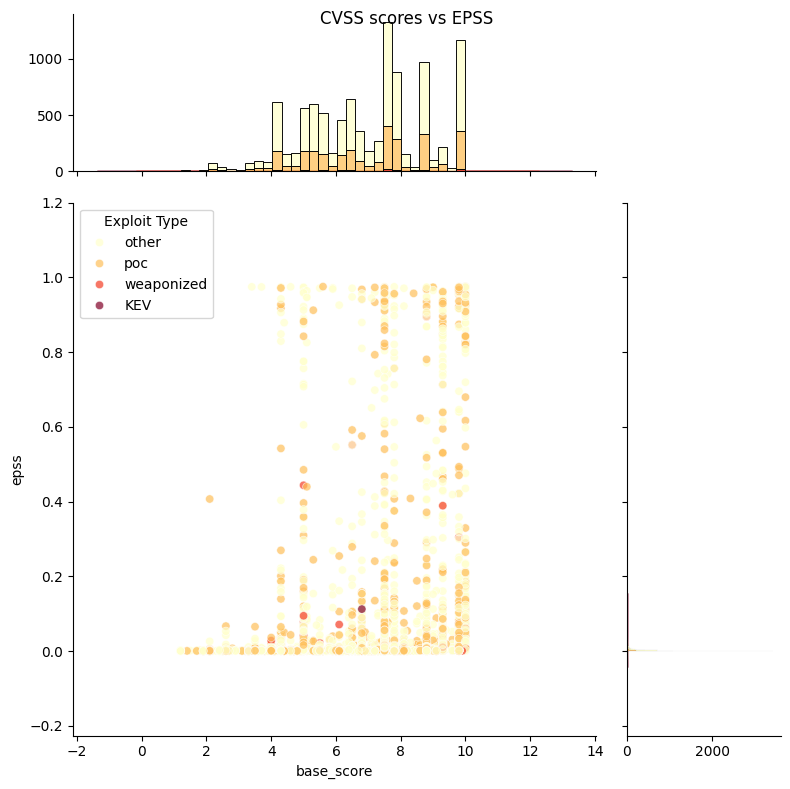

In [ ]:
plot_cve_epss_cvss(df_acme)

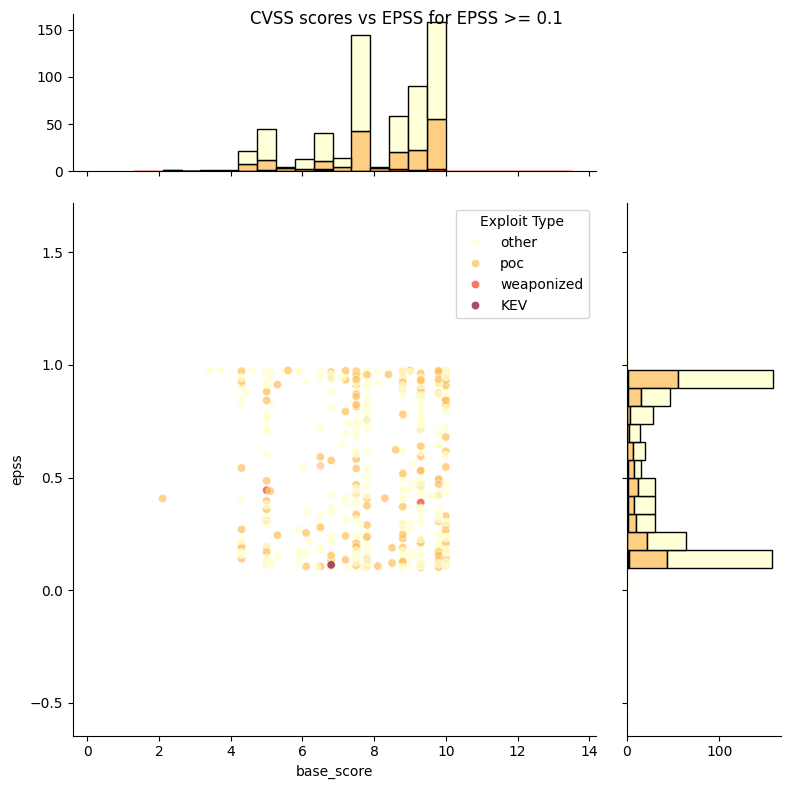

In [ ]:
df_acme_epss_01 = df_acme[df_acme['epss'] >= 0.1]
plot_cve_epss_cvss(df_acme_epss_01, title="CVSS scores vs EPSS for EPSS >= 0.1")


## EPSS Curve

See https://riskbasedprioritization.github.io/epss/EPSS_Thresholds/#policy-applied-to-an-enterprise for more info on this.

In [ ]:
filtered_df_acme = df_acme[~(df_acme['cisa_kev'] | df_acme['vulncheck_kev'] | df_acme['metasploit'] | df_acme['nuclei'])]
filtered_df_acme

,cve,cvss-bt_score,cvss-bt_severity,cvss-bt_vector,cvss_version,base_score,base_severity,base_vector,assigner,published_date,epss,cisa_kev,vulncheck_kev,exploitdb,metasploit,nuclei,poc_github,EPSS_Percentile,exploitation
0,CVE-2020-2756,3.4,LOW,CVSS:3.1/AV:N/AC:H/PR:N/UI:N/S:U/C:N/I:N/A:L/E:U,3.1,3.7,LOW,CVSS:3.1/AV:N/AC:H/PR:N/UI:N/S:U/C:N/I:N/A:L,secalert_us@oracle.com,2020-04-15T14:15Z,0.00300,False,False,False,False,False,False,0.688332,1.0
1,CVE-2019-20387,6.9,MEDIUM,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:N/I:N/A:H/E:U,3.1,7.5,HIGH,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:N/I:N/A:H,cve@mitre.org,2020-01-21T23:15Z,0.00185,False,False,False,False,False,False,0.547397,0.0
2,CVE-2019-7069,8.1,HIGH,CVSS:3.0/AV:N/AC:L/PR:N/UI:R/S:U/C:H/I:H/A:H/E:U,3.0,8.8,HIGH,CVSS:3.0/AV:N/AC:L/PR:N/UI:R/S:U/C:H/I:H/A:H,psirt@adobe.com,2019-05-24T19:29Z,0.00628,False,False,False,False,False,False,0.785063,0.0
3,CVE-2018-1999006,4.0,MEDIUM,CVSS:3.0/AV:N/AC:L/PR:L/UI:N/S:U/C:L/I:N/A:N/E:U,3.0,4.3,MEDIUM,CVSS:3.0/AV:N/AC:L/PR:L/UI:N/S:U/C:L/I:N/A:N,cve@mitre.org,2018-07-23T19:29Z,0.00053,False,False,False,False,False,False,0.188455,0.0
4,CVE-2022-21434,4.9,MEDIUM,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:N/I:L/A:N/E:U,3.1,5.3,MEDIUM,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:N/I:L/A:N,secalert_us@oracle.com,2022-04-19T21:15Z,0.00113,False,False,False,False,False,False,0.436885,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,CVE-2023-4721,5.1,MEDIUM,CVSS:3.1/AV:L/AC:L/PR:N/UI:R/S:U/C:N/I:N/A:H/E:U,3.1,5.5,MEDIUM,CVSS:3.1/AV:L/AC:L/PR:N/UI:R/S:U/C:N/I:N/A:H,security@huntr.dev,2023-09-01T16:15Z,0.00044,False,False,False,False,False,False,0.097464,0.0
9996,CVE-2022-36988,8.1,HIGH,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H/E:U,3.1,8.8,HIGH,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H,cve@mitre.org,2022-07-28T01:15Z,0.00102,False,False,False,False,False,False,0.404972,0.0
9997,CVE-2018-2488,7.1,HIGH,CVSS:3.0/AV:L/AC:L/PR:N/UI:R/S:U/C:H/I:H/A:H/E:U,3.0,7.8,HIGH,CVSS:3.0/AV:L/AC:L/PR:N/UI:R/S:U/C:H/I:H/A:H,cna@sap.com,2018-11-13T20:29Z,0.00070,False,False,False,False,False,False,0.285852,0.0
9998,CVE-2015-1420,1.6,LOW,AV:L/AC:M/Au:N/C:P/I:N/A:N/E:U,2.0,1.9,LOW,AV:L/AC:M/Au:N/C:P/I:N/A:N,cve@mitre.org,2015-03-16T10:59Z,0.00044,False,False,False,False,False,False,0.097464,0.0


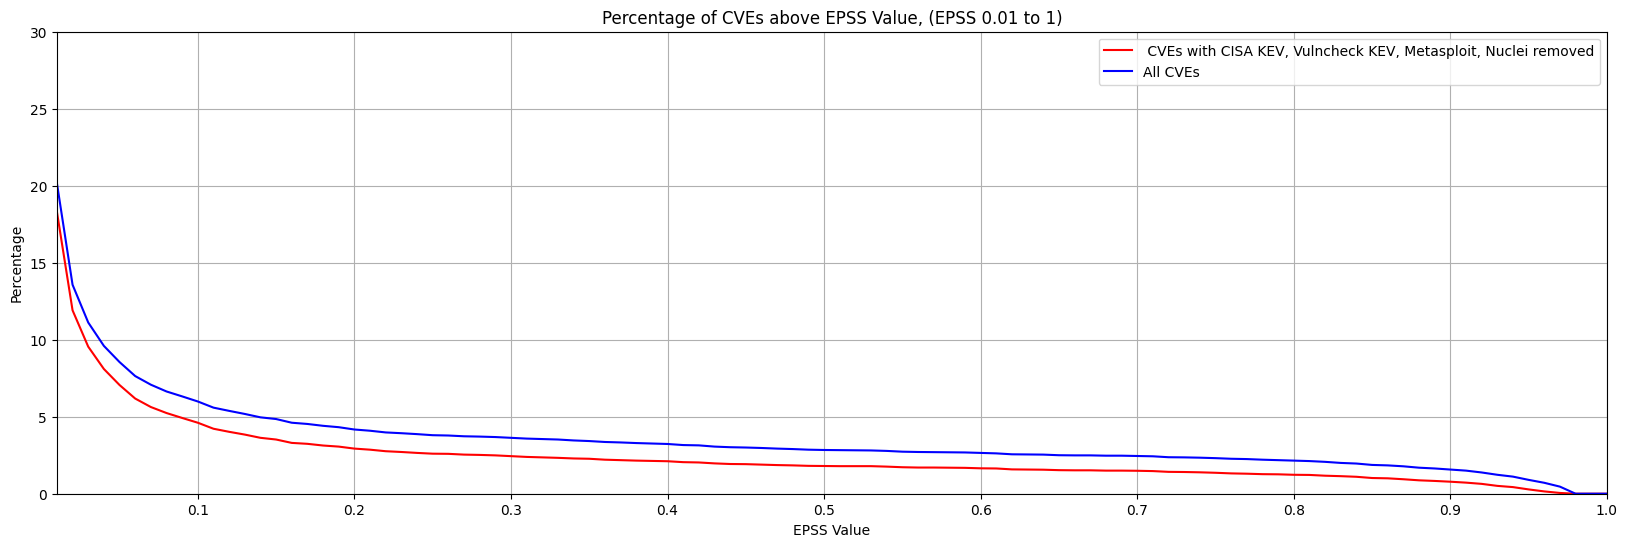

In [ ]:
import numpy as np  # Import NumPy for array operations

# Define the range of values from 0 to 1
value_range = np.linspace(0, 1, 101)  # Values from 0.00 to 1.00 in steps of 0.01

# Calculate total count for normalization
total_count = len(df_acme['epss'])

# Calculate cumulative percentages for each value in the range
cumulative_percentages = [((df_acme['epss'] >= value).sum() / total_count) * 100 for value in value_range]

# Calculate cumulative percentages for filtered data
cumulative_percentages_filtered = [((filtered_df_acme['epss'] >= value).sum() / total_count) * 100 for value in value_range]

# Create a cumulative histogram
plt.figure(figsize=(20, 6))

plt.plot(value_range, cumulative_percentages_filtered, linestyle='-', color='r', label=' CVEs with CISA KEV, Vulncheck KEV, Metasploit, Nuclei removed')
plt.plot(value_range, cumulative_percentages, linestyle='-', color='b', label='All CVEs')

plt.title('Percentage of CVEs above EPSS Value, (EPSS 0.01 to 1)')
plt.xlabel('EPSS Value')
plt.ylabel('Percentage')
plt.yscale('linear')
plt.xlim(0.01, 1)
plt.ylim(0, 30)  # Adjust ylim to show percentages from 0 to 100

plt.xticks(np.arange(0.1, 1.1, 0.1))  # Set major ticks at every 0.1 step on the x-axis


plt.grid(True)
plt.legend()
plt.show()

## EPSS Percentiles

See https://riskbasedprioritization.github.io/epss/Applying_EPSS_to_your_environment/#epss-percentile-score-for-your-environment for more info on this.

In [ ]:
df_acme
df_acme['ACME_EPSS_Percentile'] = percentile_rank(df_acme['epss'])
df_acme

,cve,cvss-bt_score,cvss-bt_severity,cvss-bt_vector,cvss_version,base_score,base_severity,base_vector,assigner,published_date,epss,cisa_kev,vulncheck_kev,exploitdb,metasploit,nuclei,poc_github,EPSS_Percentile,exploitation,ACME_EPSS_Percentile
0,CVE-2020-2756,3.4,LOW,CVSS:3.1/AV:N/AC:H/PR:N/UI:N/S:U/C:N/I:N/A:L/E:U,3.1,3.7,LOW,CVSS:3.1/AV:N/AC:H/PR:N/UI:N/S:U/C:N/I:N/A:L,secalert_us@oracle.com,2020-04-15T14:15Z,0.00300,False,False,False,False,False,False,0.688332,1.0,0.635891
1,CVE-2019-20387,6.9,MEDIUM,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:N/I:N/A:H/E:U,3.1,7.5,HIGH,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:N/I:N/A:H,cve@mitre.org,2020-01-21T23:15Z,0.00185,False,False,False,False,False,False,0.547397,0.0,0.498486
2,CVE-2019-7069,8.1,HIGH,CVSS:3.0/AV:N/AC:L/PR:N/UI:R/S:U/C:H/I:H/A:H/E:U,3.0,8.8,HIGH,CVSS:3.0/AV:N/AC:L/PR:N/UI:R/S:U/C:H/I:H/A:H,psirt@adobe.com,2019-05-24T19:29Z,0.00628,False,False,False,False,False,False,0.785063,0.0,0.741848
3,CVE-2018-1999006,4.0,MEDIUM,CVSS:3.0/AV:N/AC:L/PR:L/UI:N/S:U/C:L/I:N/A:N/E:U,3.0,4.3,MEDIUM,CVSS:3.0/AV:N/AC:L/PR:L/UI:N/S:U/C:L/I:N/A:N,cve@mitre.org,2018-07-23T19:29Z,0.00053,False,False,False,False,False,False,0.188455,0.0,0.162292
4,CVE-2022-21434,4.9,MEDIUM,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:N/I:L/A:N/E:U,3.1,5.3,MEDIUM,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:N/I:L/A:N,secalert_us@oracle.com,2022-04-19T21:15Z,0.00113,False,False,False,False,False,False,0.436885,0.0,0.387077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,CVE-2023-4721,5.1,MEDIUM,CVSS:3.1/AV:L/AC:L/PR:N/UI:R/S:U/C:N/I:N/A:H/E:U,3.1,5.5,MEDIUM,CVSS:3.1/AV:L/AC:L/PR:N/UI:R/S:U/C:N/I:N/A:H,security@huntr.dev,2023-09-01T16:15Z,0.00044,False,False,False,False,False,False,0.097464,0.0,0.081928
9996,CVE-2022-36988,8.1,HIGH,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H/E:U,3.1,8.8,HIGH,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H,cve@mitre.org,2022-07-28T01:15Z,0.00102,False,False,False,False,False,False,0.404972,0.0,0.358607
9997,CVE-2018-2488,7.1,HIGH,CVSS:3.0/AV:L/AC:L/PR:N/UI:R/S:U/C:H/I:H/A:H/E:U,3.0,7.8,HIGH,CVSS:3.0/AV:L/AC:L/PR:N/UI:R/S:U/C:H/I:H/A:H,cna@sap.com,2018-11-13T20:29Z,0.00070,False,False,False,False,False,False,0.285852,0.0,0.254518
9998,CVE-2015-1420,1.6,LOW,AV:L/AC:M/Au:N/C:P/I:N/A:N/E:U,2.0,1.9,LOW,AV:L/AC:M/Au:N/C:P/I:N/A:N,cve@mitre.org,2015-03-16T10:59Z,0.00044,False,False,False,False,False,False,0.097464,0.0,0.081928


## Plot ACME EPSS Percentiles against EPSS Percentile for all CVEs

If ACME org has
- lots of CVEs with a high EPSS score then the curve will be further below the diagonal - because a CVE with high EPSS will have less CVEs below it given ACME has more higher EPSS CVEs
- a random sample of CVEs, then the curve will be on the diagonal

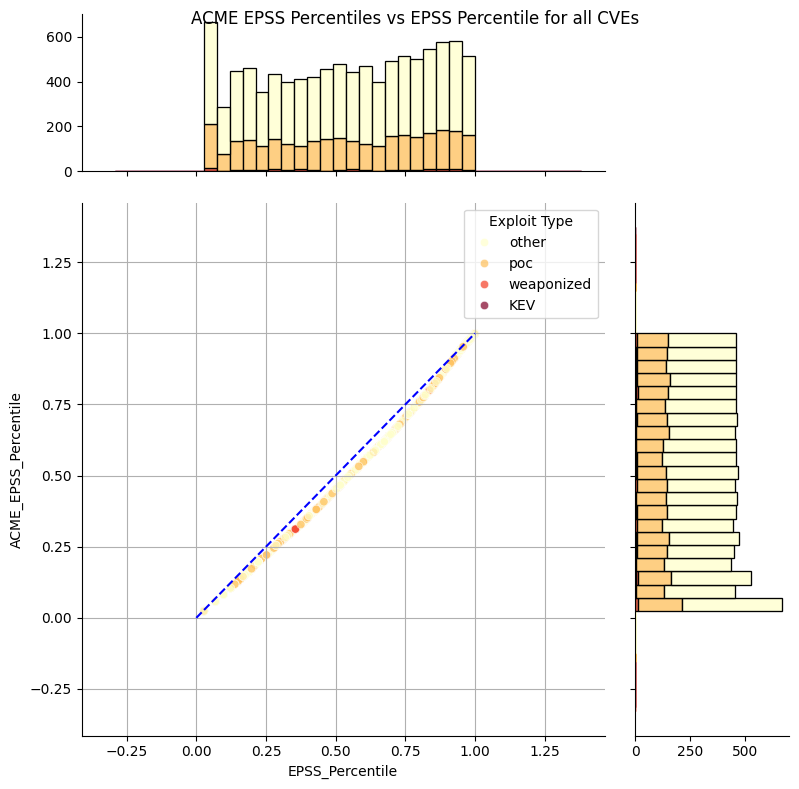

In [ ]:
title= "ACME EPSS Percentiles vs EPSS Percentile for all CVEs"
colorscale = 'YlOrRd' #Yellow Orange Red
g=sns.jointplot(data=df_acme, x='EPSS_Percentile', y='ACME_EPSS_Percentile', kind='scatter', height=8, ratio=3, marginal_ticks=True, alpha=.7, hue="exploitation", palette=colorscale)
handles, labels = g.ax_joint.get_legend_handles_labels()
g.ax_joint.legend(handles=handles, labels = ['other', 'poc', 'weaponized',  'KEV'], title="Exploit Type")
g.plot_marginals(sns.histplot, multiple="stack")
g.fig.suptitle(title)
# Plot diagonal line
g.ax_joint.plot([0, 1], [0, 1], color='blue', linestyle='--')  # Diagonal line from (0,0) to (1,1)
plt.grid(True)
plt.show()